In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import scipy.io
import os
npr.seed(0)
from ipywidgets import widgets

import ssm
import smartload.smartload as smart
from ssm.util import find_permutation, split_by_trials
from ssm.plots import gradient_cmap, white_to_color_cmap
from ssm.exputils import load_multiple_sessions, load_session, make_savedict, run_and_save, get_id_range, sigmoid
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib notebook

# Speficy whether or not to save figures
save_figures = True

%reload_ext autoreload
%autoreload 2
# %matplotlib widget

In [17]:
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 3    # number of discrete states
obs_dim = 30       # dimensionality of observation

# Make an HMM
np.random.seed(128)
true_hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

true_hmm.observations.mus = np.array([1, 9, 4]).T
true_hmm.observations.sigmas = np.array([0.8, 1.5, 2]).T
true_hmm.observations.lapses = np.array([0.2, 0.05, 0.4]).T

# true_hmm.transitions.transition_matrix = np.array([[0.98692759, 0.01307241],
#                                        [0.00685383, 0.99314617]])


# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

arr=  true_hmm.observations.log_likelihoods(obs, None, None, None)

true_ll = true_hmm.log_probability(obs)

<IPython.core.display.Javascript object>


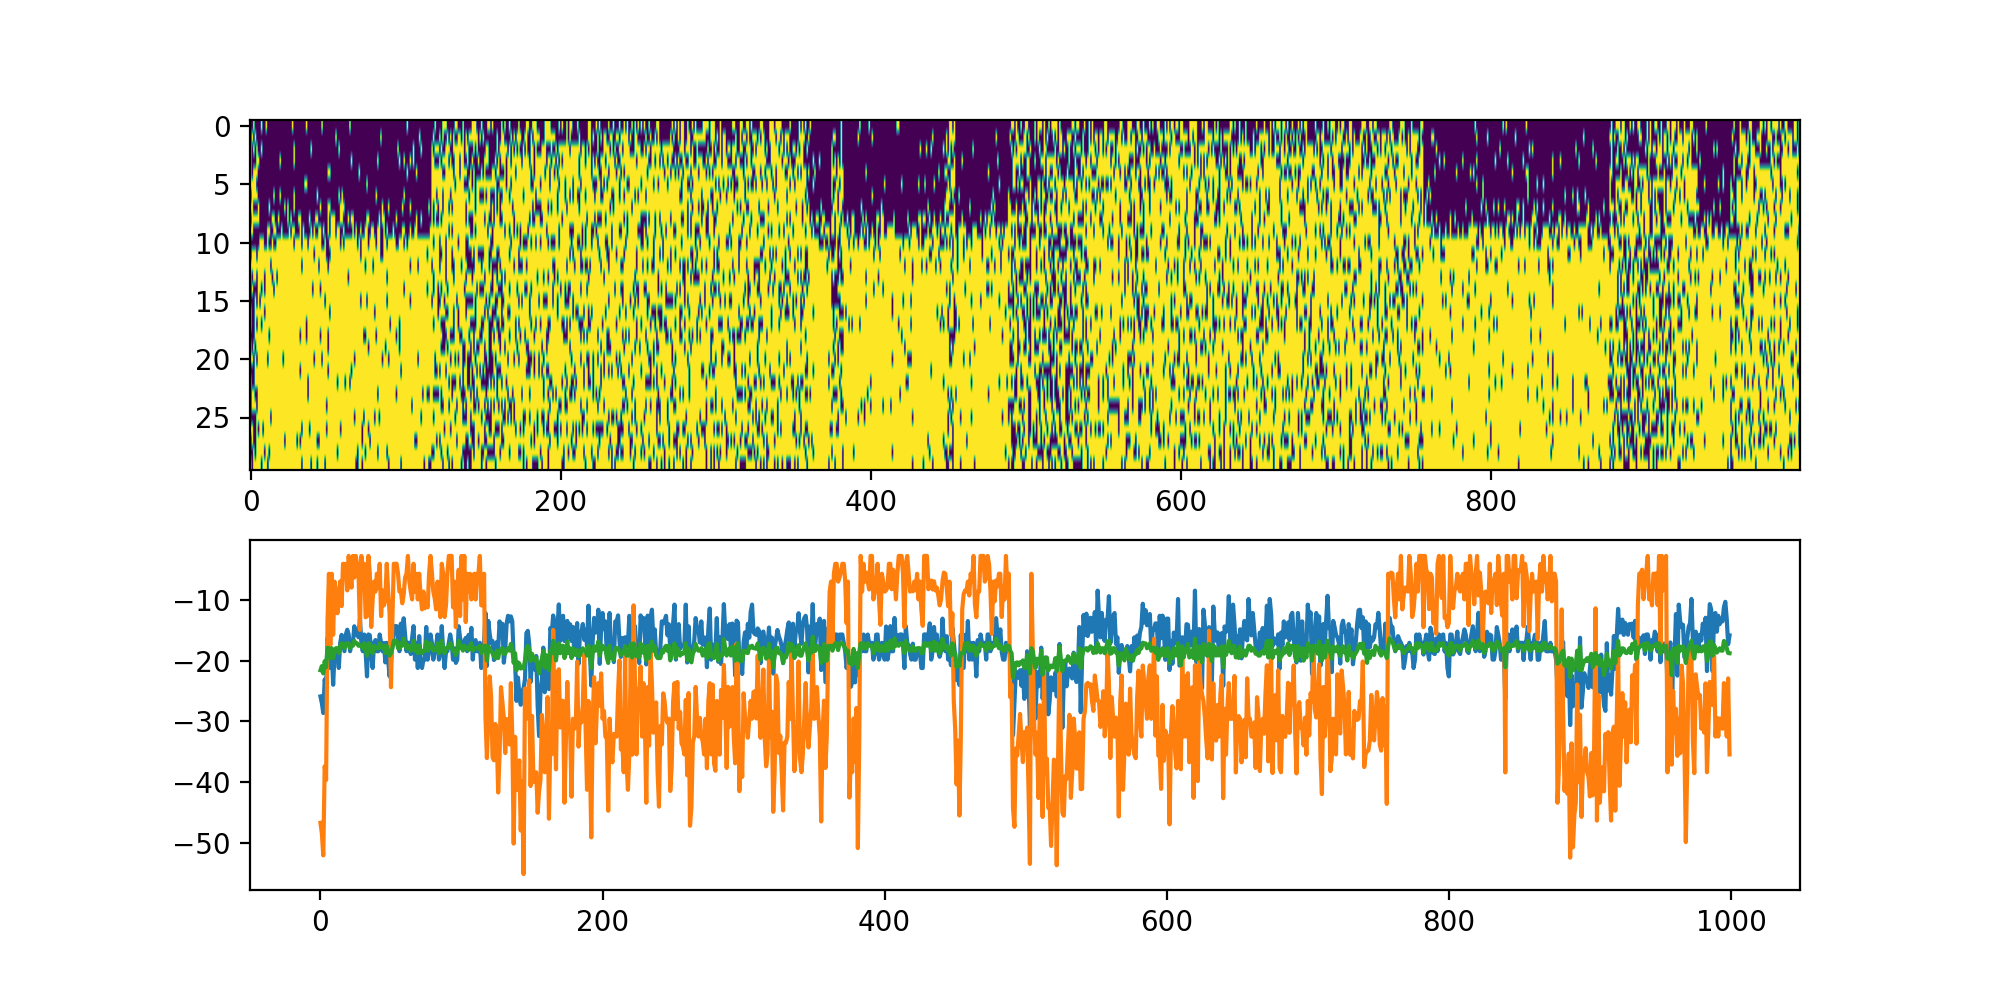

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.imshow(obs.T, aspect='auto')
plt.subplot(212)
plt.plot(arr)

In [29]:
np.arange(2,8)

array([2, 3, 4, 5, 6, 7])

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


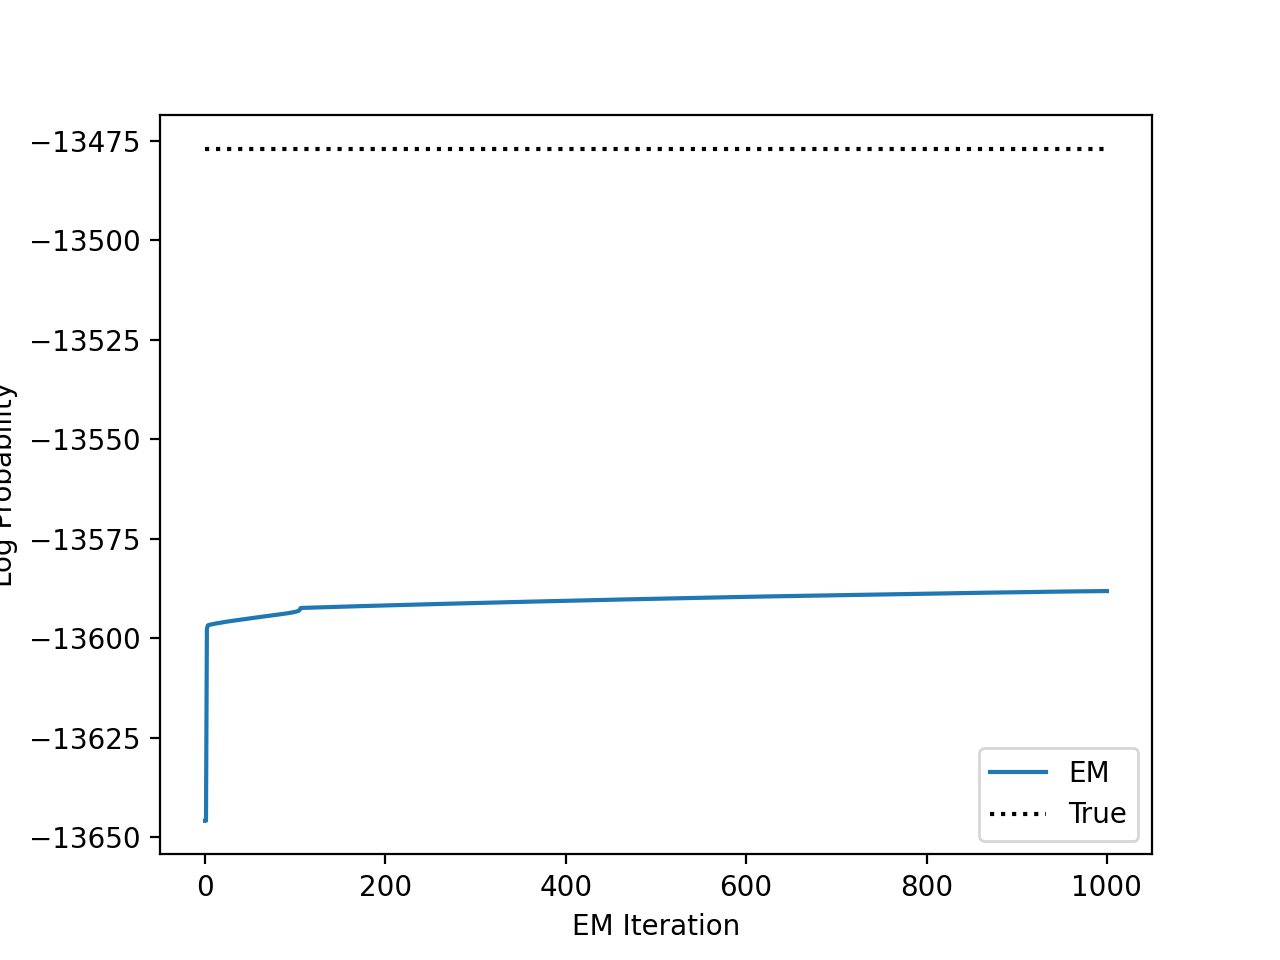

In [19]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 1000

# np.random.seed(123)

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.figure()
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


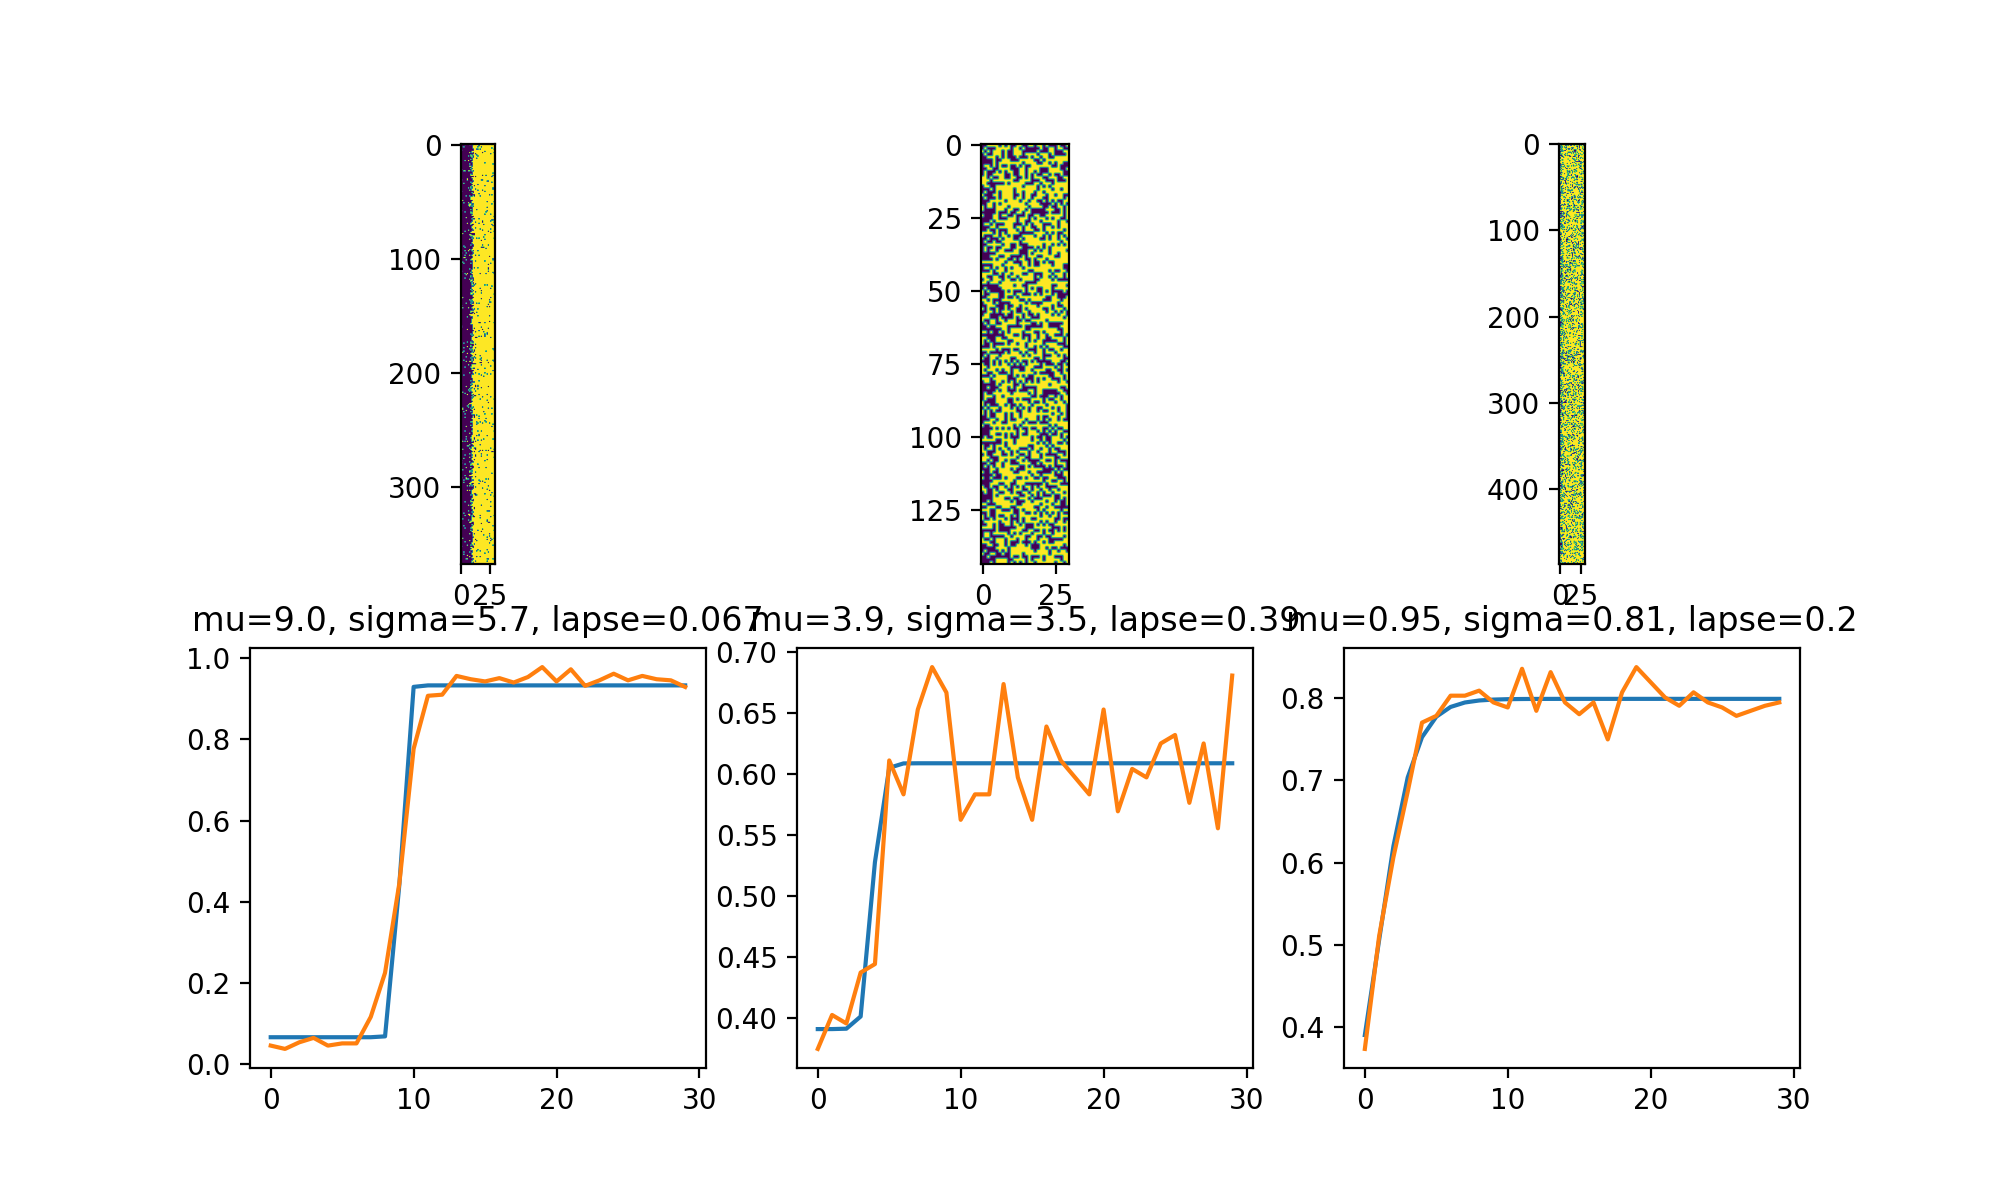

In [20]:
def sigmoid(x, mu, sigma, lapse=0):
    return lapse + (1-2*lapse) / (1 + np.exp(-(x - mu) * sigma))

# hmm.permute([1,3,0,2])

# Pool states and visualize
zstates = hmm.most_likely_states(obs)
obs_clustered = list(map(lambda x: obs[(zstates == x),:], np.unique(zstates)))

# Construct the block transition function for each mode
mus, sigmas, lapses = hmm.observations.params

transfuncs = list(map(lambda mu,sigma, lapse: sigmoid(np.arange(hmm.D), mu, sigma, lapse), mus, sigmas, lapses))
plt.figure(figsize=(10,6))

for i in range(num_states):
    plt.subplot(2,num_states,i+1)
    plt.imshow(obs_clustered[i])
    
    plt.subplot(2, num_states, i+1+num_states)
    plt.plot(transfuncs[i])
    plt.plot(np.nanmean(obs_clustered[i], axis=0))
    
    plt.title(f'mu={mus[i][0]:.2}, sigma={sigmas[i][0]:.2}, lapse={lapses[i][0]:.2}')
    


In [24]:
obs.shape

(1000, 30)

In [25]:
hmm.log_likelihood(obs[:30,:])

-310.1302112269072

In [19]:
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

In [20]:
np.squeeze(np.array(hmm.observations.params)).shape

(3, 2)

<IPython.core.display.Javascript object>


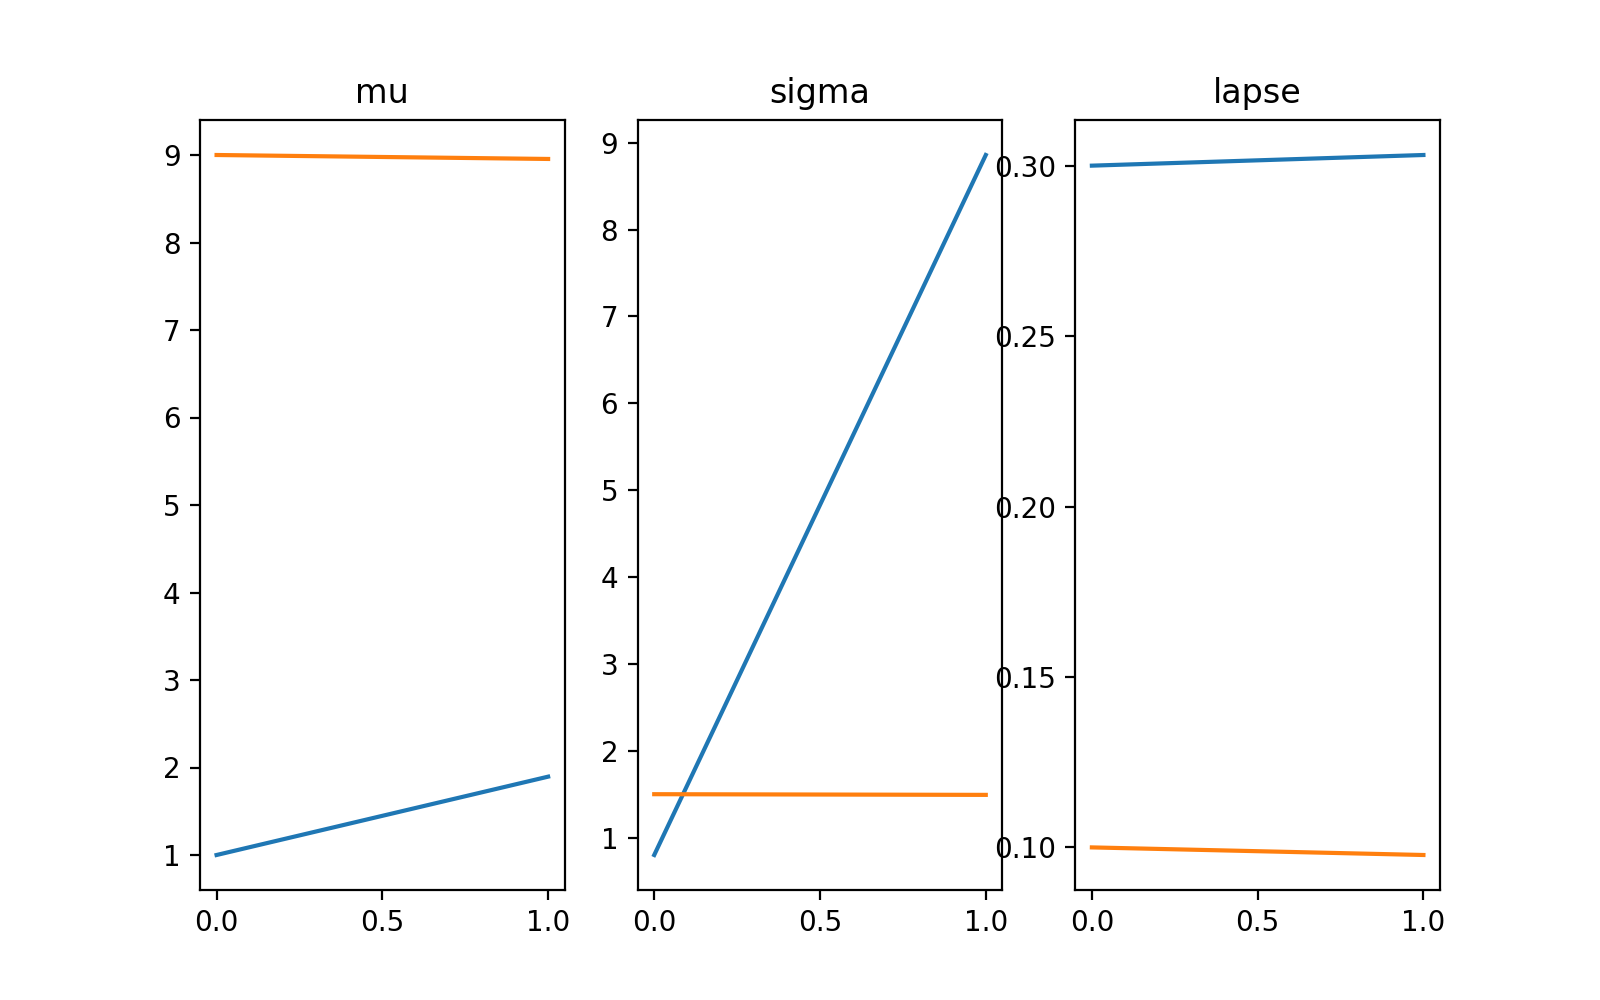

In [21]:
# Comparing the true and inferred parameters
true_params = np.squeeze(np.array(true_hmm.observations.params))
sim_params = np.squeeze(np.array(hmm.observations.params))

# true_mus, true_sigmas, true_lapses = true_hmm.observations.params
# sim_mus, sim_sigmas, sim_lapses = hmm.observations.params
titles = ['mu', 'sigma', 'lapse']
nparams = true_params.shape[0]
plt.figure(figsize=(8,5))
for j in range(nparams):
    plt.subplot(1,nparams,j+1)
    for i in range(hmm.K):
        plt.plot(np.arange(hmm.K), [true_params[j,i], sim_params[j,i]])
        plt.title(titles[j])
    
# plt.subplot(122)
# for i in range(hmm.K):
#     plt.plot(np.arange(hmm.K), [true_params[1,i], sim_params[1,i]])
    
# plt.subplot(122)
# for i in range(hmm.K):
#     plt.plot(np.arange(hmm.K), [true_params[1,i], sim_params[1,i]])
    
    
    

<IPython.core.display.Javascript object>


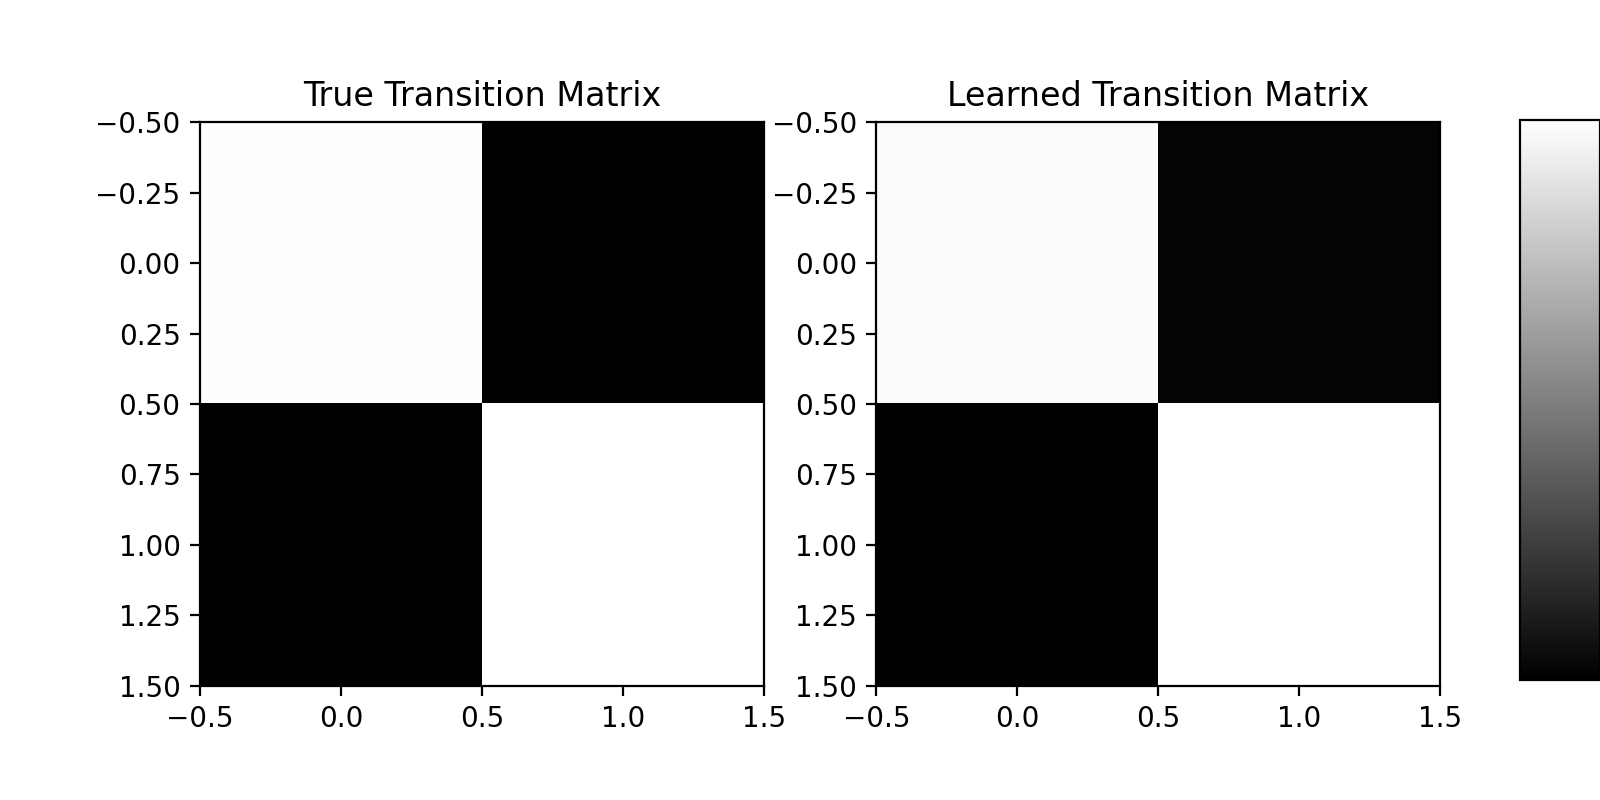

In [22]:
# Note: rows correspond to origin state, columns are destinations
# so that (i,j) entry corresponds to P(z_t+1 = j | z_t = i)
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


## Fit to animal behavior

In [10]:
datarange['animals']

array(['e35', 'e40', 'e46', 'e50', 'e53', 'e54', 'e56', 'e57', 'f01',
       'f02', 'f03', 'f04', 'f11', 'f12', 'f16', 'f17', 'f20', 'f21',
       'f22', 'f23', 'fh01', 'fh02', 'fh03'], dtype=object)

In [9]:
# Note: run script /Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/matlab/compile_behavioral_sessions.m to produce _all_sessions files
#TODOs:
# -Handle nan choices
# - Faster optimization and avoid local minima?

# Load data
animal = 'e35'
version = '_113021'
filepath = f'/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expdata/{animal}_all_sessions{version}.mat'
fitrangefile = '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expdata/fitranges_102121.mat'

datarange = smart.loadmat(fitrangefile)
fitrange = datarange['ranges'][datarange['animals'] == animal][0]
# fitrange = get_id_range(filepath)
obs, lengths, dirs, fnames, rawchoices = load_multiple_sessions(filepath, fitrange, trialsperblock=15)

# Find the foraging efficiencies of all blocks
block_lens = []
block_corrs = []
for i in range(len(rawchoices)):
    arr = rawchoices[i]
    block_corrs += list(np.nansum(arr == 1, axis=1))
    block_lens += list(np.sum(~np.isnan(arr), axis=1))

100%|██████████| 35/35 [00:00<00:00, 781.02it/s]


/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
/Users/minhnhatle/Documents/ExternalCode/ssm/ssm/optimizers.py:149: UserWarning: L-BFGS-B failed with message:
ABNORMAL_TERMINATION_IN_LNSRCH
  warn("{} failed with message:\n{}".format(method, result.message))


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


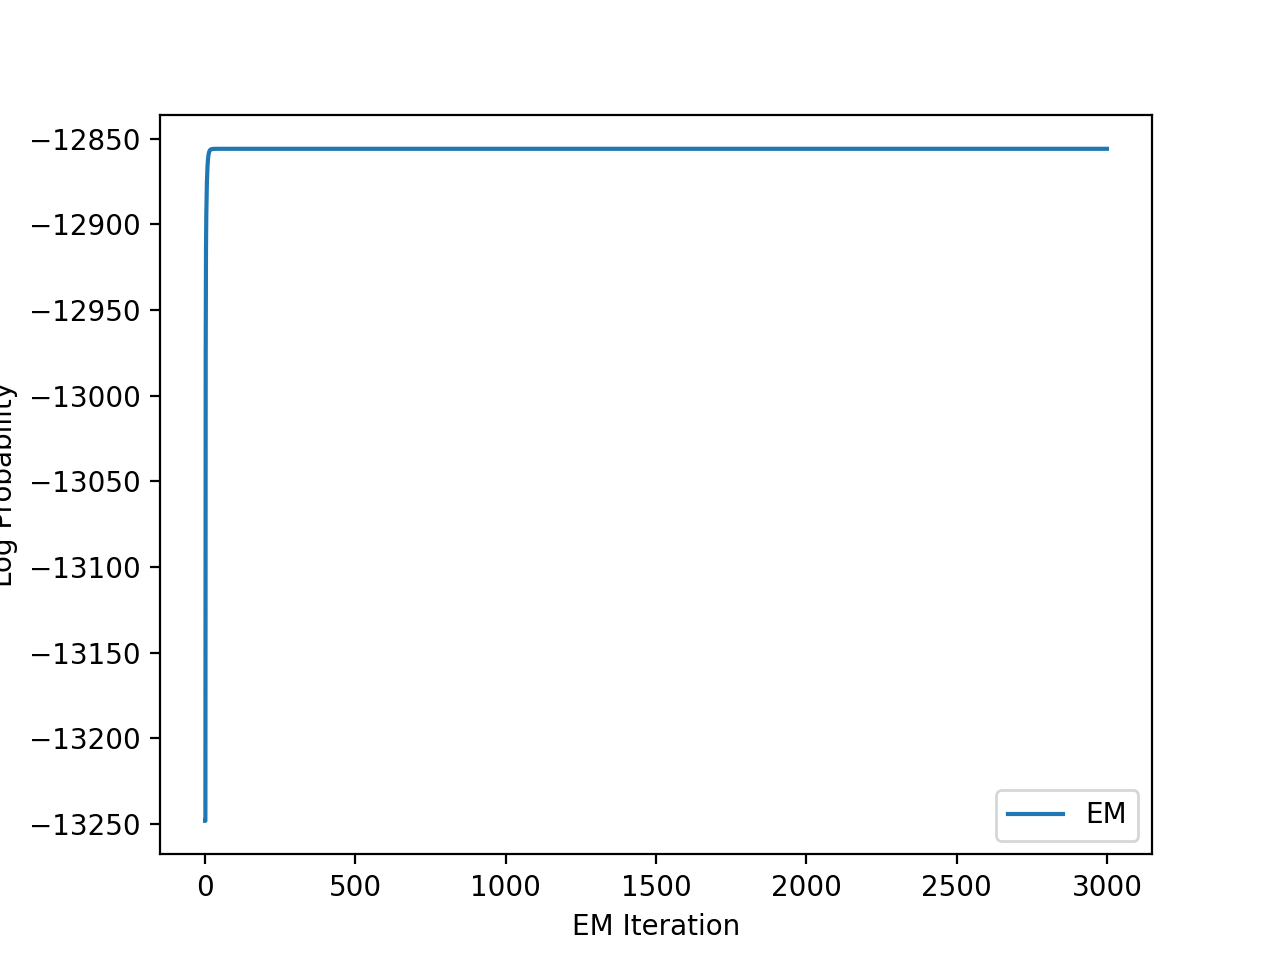

In [5]:
masks = ~np.isnan(obs)
obsmasked = obs[:]
obsmasked[~masks] = 1

N_iters = 3000
obs_dim = obs.shape[1]
num_states = 4
seed = 124
np.random.seed(seed)

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

hmm_lls = hmm.fit(obs, method="em", masks=masks, num_iters=N_iters, init_method="kmeans")

plt.figure()
plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


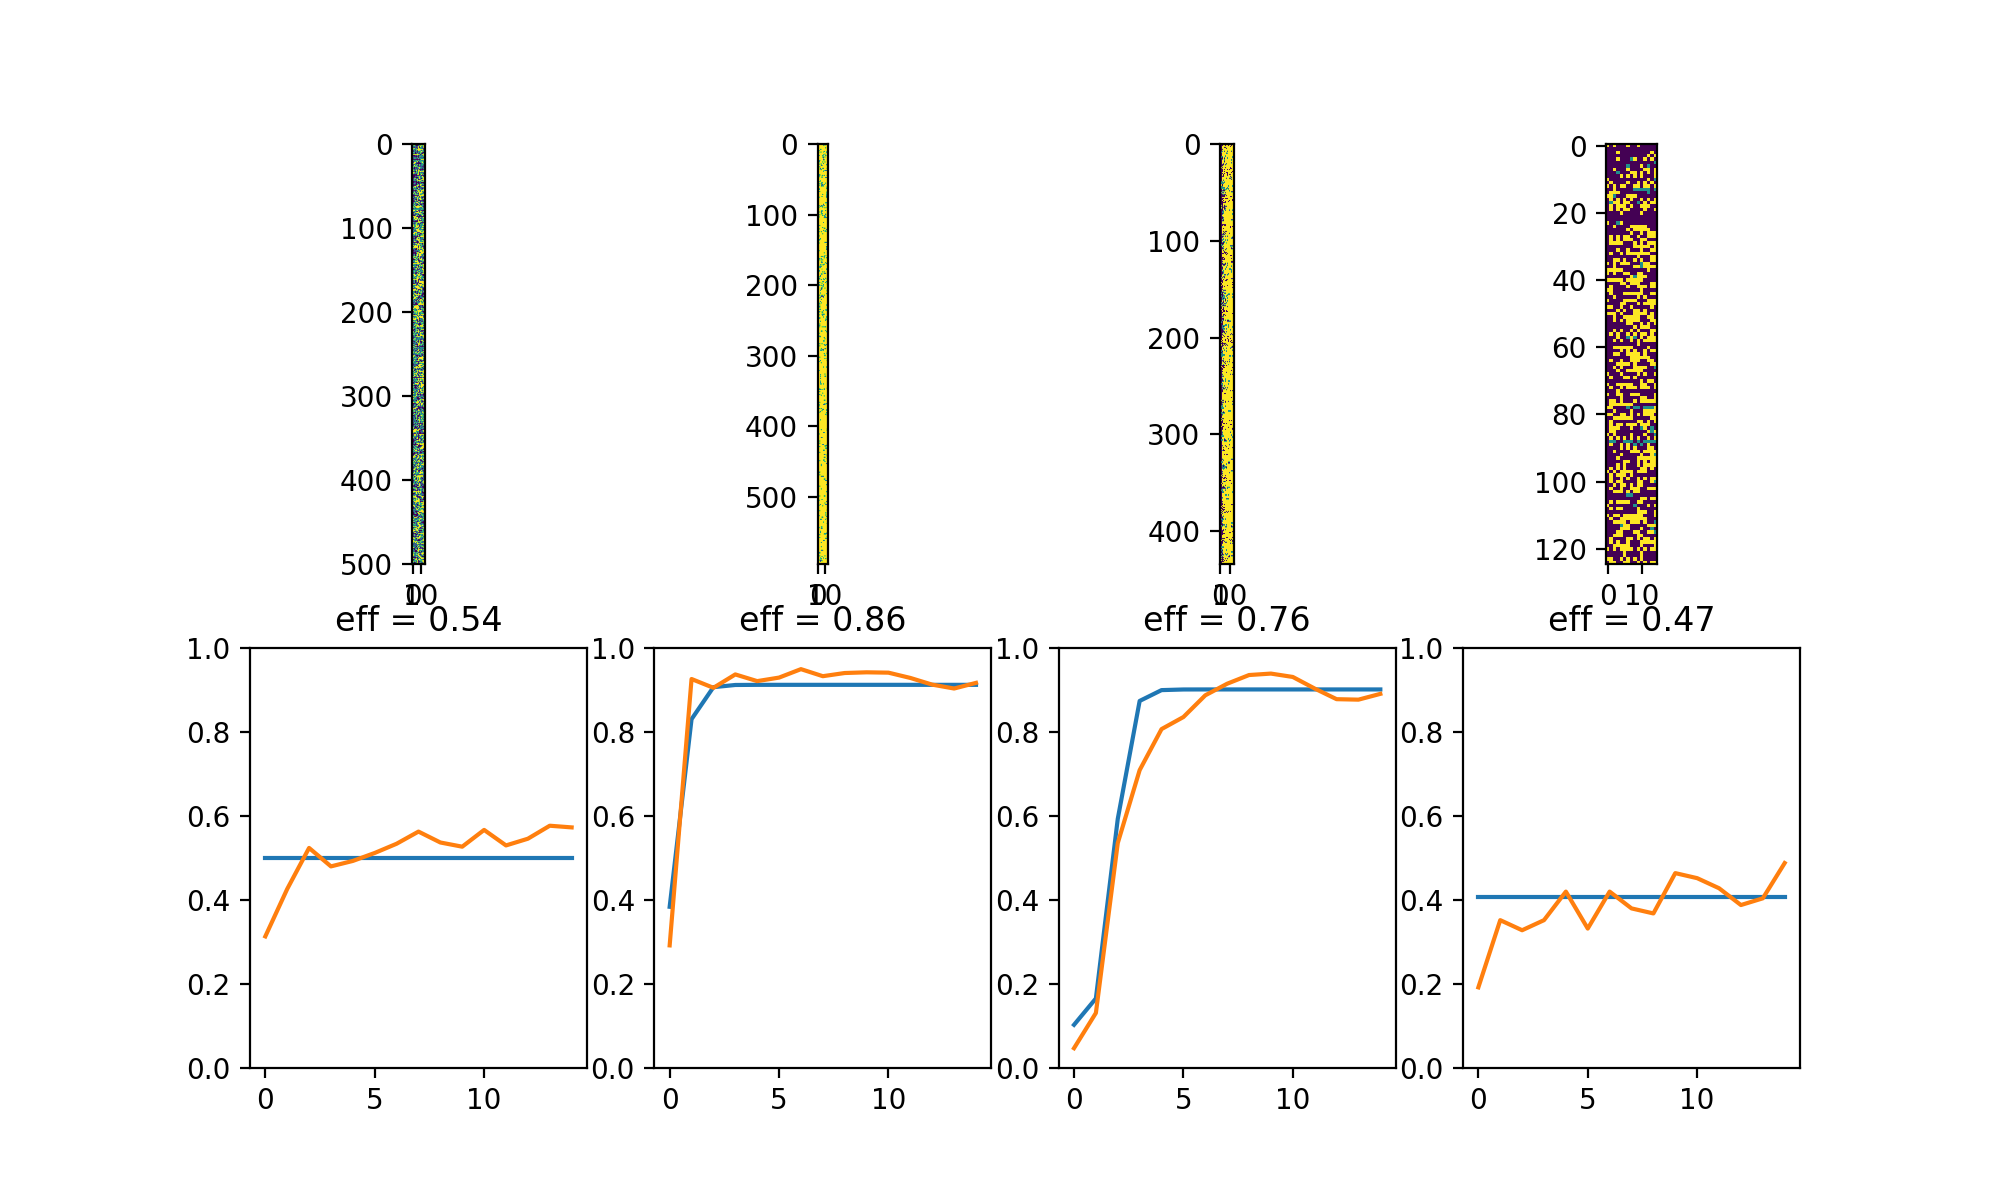

In [6]:
# perm_order = [2,1,0,3]
# hmm.permute(perm_order)

# Pool states and visualize
zstates = hmm.most_likely_states(obs)
obs_clustered = [obs[zstates == i, :] for i in np.unique(zstates)]

# Construct the block transition function for each mode
mus, sigmas, lapses = hmm.observations.params

transfuncs = [sigmoid(np.arange(15), mu, sigma, lapse) for mu, sigma, lapse in zip(mus, sigmas, lapses)]
plt.figure(figsize=(10,6))

effs = []

for i in range(num_states):
    # Find the average foraging efficiency of that state
    blen_state = np.array(block_lens)[zstates == i]
    bcorr_state = np.array(block_corrs)[zstates == i]
    eff_state = sum(bcorr_state) / sum(blen_state)
    effs.append(eff_state)
    
    plt.subplot(2,num_states,i+1)
    plt.imshow(obs_clustered[i])
    
    plt.subplot(2, num_states, i+1+num_states)
    plt.plot(transfuncs[i])
    plt.plot(np.nanmean(obs_clustered[i], axis=0))
    plt.ylim([0, 1])
    
#     plt.title(f'mu={mus[i][0]:.2}, sigma={sigmas[i][0]:.2}, lapse={lapses[i][0]:.2}')
    plt.title(f'eff = {eff_state:.2}')


In [94]:
# Save the result
transmat = hmm.transitions.transition_matrix
params = hmm.observations.params
savepath = f'/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expdata/{animal}_hmmblockfit{version}.mat'

vars = ['zstates', 'dirs', 'lengths', 'transmat', 'params', 
        'fitrange', 'filepath', 'obs', 'seed', 'hmm_lls', 'effs', 'block_lens', 'block_corrs']
savedict = make_savedict(vars, globals())

savefile = 1
if savefile and not os.path.exists(savepath):
    scipy.io.savemat(savepath, savedict)
    print('File saved')
elif os.path.exists(savepath):
    print('File exists, skipping save..')
    


File saved


<IPython.core.display.Javascript object>


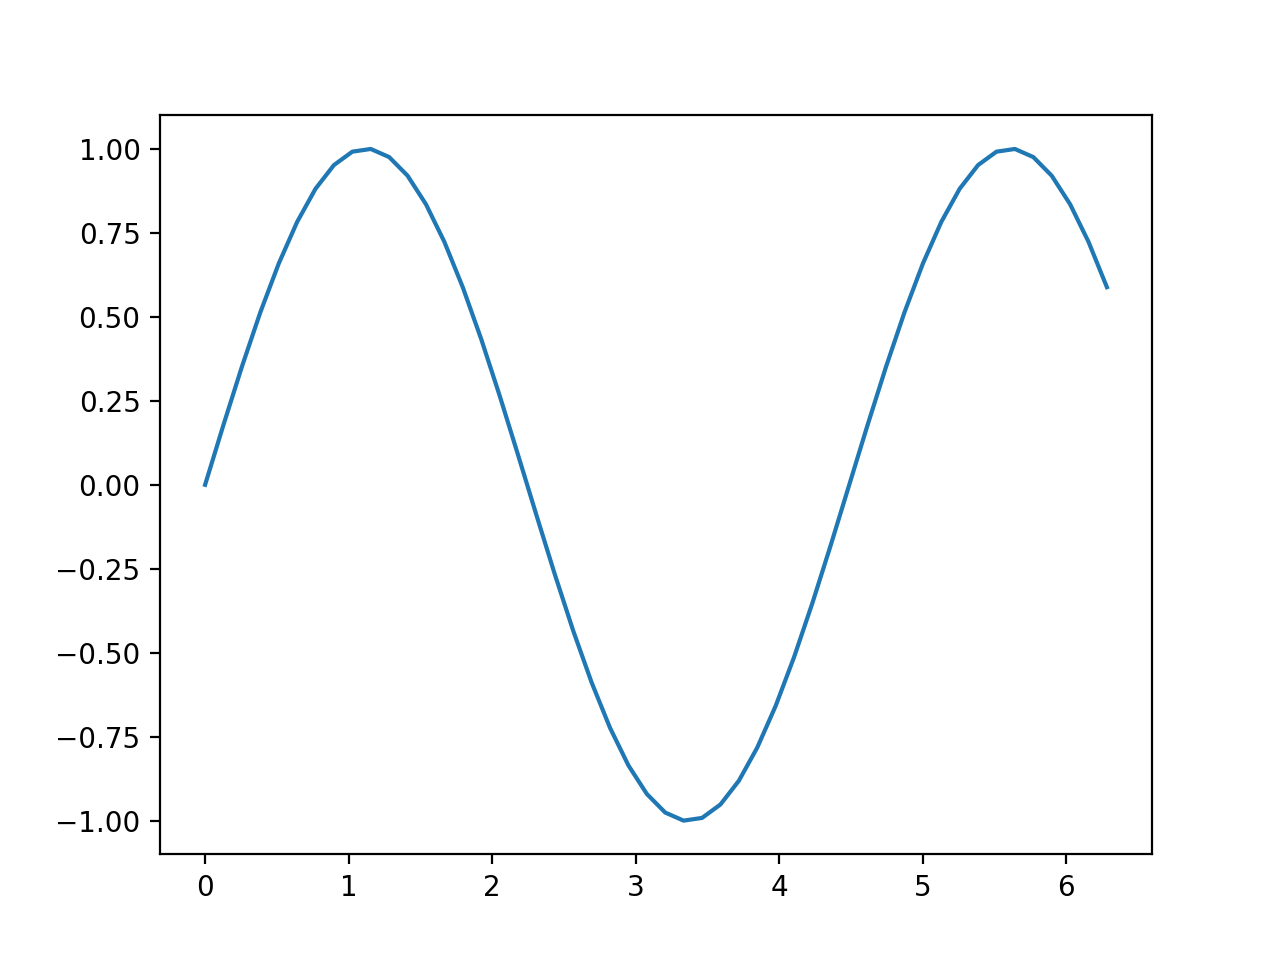

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

<function __main__.update(w=1.0)>

In [1]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    plt.show()

interact(update)


In [125]:
run_and_save('f02', 'f02_hmmblockfit_102121c.mat', 1)

empty file: 0
empty file: 1
empty file: 2
empty file: 3
empty file: 4
empty file: 5


/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


  0%|          | 0/500 [00:00<?, ?it/s]

8
File saved
